In [1]:
"""
base solver for transfer ode (first order methods)
"""
import torch
import torch.nn as nn
import argparse
import torch.optim as optim
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from torchdiffeq import odeint_adjoint as odeint
from mpl_toolkits.mplot3d import Axes3D
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

%matplotlib inline


parser = argparse.ArgumentParser('transfer demo')

parser.add_argument('--tmax', type=float, default=3.14159)
parser.add_argument('--dt', type=int, default=0.05)
parser.add_argument('--niters', type=int, default=10000)
parser.add_argument('--niters_test', type=int, default=15000)
parser.add_argument('--hidden_size', type=int, default=100)
parser.add_argument('--num_bundles', type=int, default=10)
parser.add_argument('--num_bundles_test', type=int, default=10)
parser.add_argument('--test_freq', type=int, default=100)
parser.add_argument('--viz', action='store_false')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--evaluate_only', action='store_true')
args = parser.parse_args([])

/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
args.niters_test

15000

In [3]:

class diffeq(nn.Module):
    """
    defines the diffeq of interest
    """

    def __init__(self,a1, a0, f):
        super().__init__()
        self.a1 = a1
        self.a0 = a0
        self.f = f

    # return ydot
    def forward(self, t, states):
        # y = y[:, 0]
        y = states[:, 0].reshape(1, -1)
        yd = states[:, 1].reshape(1, -1)
        ydd = get_udot(t,y,yd,self.a1,self.a0,self.f)#(-self.a1(t) * yd - self.a0(t) * y + self.f(t)).reshape(-1, 1)
        return torch.cat([yd.reshape(-1,1), ydd.reshape(-1,1)], 1)

# get_udot(tv,pred_y,pred_ydot,a1_samples,a0_samples,f_samples)

def get_udot(t,y,yd,a1,a0,f):

    #a1 is 1
    # print(t.dim())
    if y.shape[0] <=1:
        a1s = torch.tensor([a_(t) for a_ in a1]).reshape(1, -1)
        a0s = torch.tensor([a_(t) for a_ in a0]).reshape(1,-1)
        f0s = torch.tensor([f_(t) for f_ in f]).reshape(1,-1)
    else:
        a1s = torch.cat([a_(t) for a_ in a1], 1)
        a0s = torch.cat([a_(t) for a_ in a0],1)
        f0s = torch.cat([f_(t) for f_ in f],1)

    ydd = (-a1s*yd -a0s * y + f0s)
    return ydd

class SiLU(nn.Module):
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return torch.sin(input)


class base_diffeq:
    """
    integrates base_solver given y0 and time
    """

    def __init__(self, base_solver):
        self.base = base_solver

    def get_solution(self, true_y0, t):
        with torch.no_grad():
            true_y = odeint(self.base, true_y0, t, method='dopri5')
        return true_y

    def get_deriv(self, true_y0, t):
        with torch.no_grad():
            true_ydot = self.base(t, true_y0)
        return true_ydot


class estim_diffeq:
    """
    integrates base_solver given y0 and time
    """

    def __init__(self, base_solver):
        self.base = base_solver

    def get_solution(self, true_y0, t):
        with torch.no_grad():
            true_y = odeint(self.base, true_y0, t, method='midpoint')
        return true_y

    def get_deriv(self, true_y0, t):
        with torch.no_grad():
            true_ydot = self.base(t, true_y0)
        return true_ydot


class ODEFunc(nn.Module):
    """
    function to learn the outputs u(t) and hidden states h(t) s.t. u(t) = h(t)W_out
    """

    def __init__(self, hidden_dim, output_dim):
        super(ODEFunc, self).__init__()
        self.hdim = hidden_dim
        self.nl = nn.Tanh()
        self.lin1 = nn.Linear(1, self.hdim)
        self.lin2 = nn.Linear(self.hdim, self.hdim)
        self.lout = nn.Linear(self.hdim, output_dim, bias=True)

    def forward(self, t):
        x = self.h(t)
        x = self.lout(x)
        return x

    def wouts(self, x):
        return self.lout(x)

    def h(self, t):
        x = self.lin1(t)
        x = self.nl(x)
        x = self.lin2(x)
        x = self.nl(x)
        return x


def diff(u, t, order=1):
    # code adapted from neurodiffeq library
    # https://github.com/NeuroDiffGym/neurodiffeq/blob/master/neurodiffeq/neurodiffeq.py
    r"""The derivative of a variable with respect to another.
    """
    # ones = torch.ones_like(u)

    der = torch.cat([torch.autograd.grad(u[:, i].sum(), t, create_graph=True)[0] for i in range(u.shape[1])], 1)
    if der is None:
        print('derivative is None')
        return torch.zeros_like(t, requires_grad=True)
    else:
        der.requires_grad_()
    for i in range(1, order):

        der = torch.cat([torch.autograd.grad(der[:, i].sum(), t, create_graph=True)[0] for i in range(der.shape[1])], 1)
        # print()
        if der is None:
            print('derivative is None')
            return torch.zeros_like(t, requires_grad=True)
        else:
            der.requires_grad_()
    return der


class Transformer_Learned(nn.Module):
    """
    returns Wout learnable, only need hidden and output dims
    """

    def __init__(self, input_dims, output_dims):
        super(Transformer_Learned, self).__init__()
        self.lin1 = nn.Linear(args.hidden_size, output_dims)

    def forward(self, x):
        return self.lin1(x)


# h, hd, hdd, true_y0, t.detach(), a1_train, a0_train, f_train)
def get_wout(s, sd,sdd, y0s, t,a1s,a0s,fs):
    # y0 = torch.stack([y0 for _ in range(len(s))]).reshape(len(s), -1)

    a0_batch = torch.cat([var_(t) for var_ in a0s], 1)
    a1_batch = torch.cat([var_(t) for var_ in a1s], 1)
    f_batch = torch.cat([var_(t) for var_ in fs], 1)
    WS = []
    for i in range(f_batch.shape[1]):
        y0 = y0s[i,:].reshape(1,-1)
        a0 = a0_batch[:,i].reshape(-1,1)
        a1 = a1_batch[:,i].reshape(-1,1)
        f = f_batch[:,i].reshape(-1,1)

        # print(a0,a1,f)
        DH = (sdd + a1 * sd + a0 * s)
        D0 = -f

        h0m = s[0].reshape(-1, 1)
        h0d = sd[0].reshape(-1, 1)
        W0 = torch.linalg.solve(DH.t() @ DH + h0m @ h0m.t() + h0d @ h0d.t(),
                                -DH.t() @ D0 + h0m @ (y0[:,0].reshape(1, -1)) + h0d @ (y0[:,1].reshape(1, -1)))
        # print(W0.shape)
        WS.append(W0)
    nWS = (torch.cat(WS)).reshape(f_batch.shape[1],-1)
    return nWS.t()


In [4]:
f_train = [lambda z: 0. * z, lambda z: 1 + 0 * z, lambda z: torch.cos(z), lambda z: torch.sin(z)]
a0_train = [lambda z: 1. + 0. * z, lambda z: 3 * z, lambda z: z ** 2]
a1_train = [lambda z: 0 * z, lambda z: z ** 2, lambda z: z ** 3]
r1 = -5.
r2 = 5.
true_y0 = (r2 - r1) * torch.rand(100, 2) + r1
t = torch.arange(0., args.tmax, args.dt).reshape(-1, 1)
t.requires_grad = True
tmax = torch.tensor([[np.pi]])
tmax.requires_grad = True

t = torch.cat([t, tmax], 0)

# sample each parameter to build the tuples
f_samples = random.choices(f_train, k=args.num_bundles_test)
a0_samples = random.choices(a0_train, k=args.num_bundles_test)
a1_samples = random.choices(a1_train, k=args.num_bundles_test)
y0_samples = true_y0[torch.tensor(random.choices(range(len(true_y0)), k=args.num_bundles_test))]

diffeq_init = diffeq(a1_samples, a0_samples, f_samples)
gt_generator = base_diffeq(diffeq_init)
true_y = gt_generator.get_solution(y0_samples, t.ravel())

NDIMZ = args.hidden_size

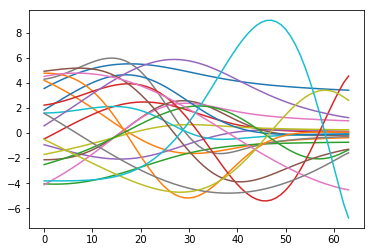

In [6]:
for i in range(10):
    plt.plot(true_y[:,i])

#### Training from Scratch

In [7]:

func = ODEFunc(hidden_dim=NDIMZ, output_dim=args.num_bundles_test)
# func.load_state_dict(torch.load('func_ffnn_bundles'))

# for name,param in func.named_parameters():
#     if name == 'lout.weight':
# #         param = nn.Parameter(wout)
    
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
        
        
optimizer = optim.Adam(func.parameters(), lr=1e-3)

residuals_scratch = []

for itr in range(1, args.niters + 1):
    # add t0 to training times, including randomly generated ts
        t0 = torch.tensor([[0.]])
        t0.requires_grad = True
        tr = args.tmax * torch.rand(int(args.tmax / args.dt))[:100].reshape(-1, 1)
        tr.requires_grad = True
        tv = torch.cat([t0, tr], 0)
        optimizer.zero_grad()
        pred_y = func(tv)
        pred_ydot = diff(pred_y, tv)
        pred_yddot = diff(pred_ydot,tv)
        loss_diffeq = pred_yddot - get_udot(tv,pred_y,pred_ydot,a1_samples,a0_samples,f_samples)
        loss_ics = torch.mean((pred_y[0, :].ravel() - y0_samples[:,0].ravel())**2) + torch.mean((pred_ydot[0,:].ravel()-y0_samples[:,1].ravel())**2)
        loss = torch.mean(torch.square(loss_diffeq)) + torch.mean(loss_ics)
        loss.backward()
        optimizer.step()
#         loss_collector.append(torch.square(loss_diffeq).mean().item())
        if itr % args.test_freq == 0:
            func.eval()
            pred_y = func(t)
            pred_ydot = diff(pred_y,t)
            pred_yddot = diff(pred_ydot,t)

            pred_y = pred_y.detach()
            pred_ydot = pred_ydot.detach()
            pred_yddot = pred_yddot.detach()

            current_residual = torch.mean((pred_yddot - get_udot(t,pred_y,pred_ydot,a1_samples,a0_samples,f_samples))**2)
            residuals_scratch.append(current_residual.item())
            print(residuals_scratch[-1])

1.8771283626556396
0.7193947434425354
0.592974066734314
0.5369520783424377
0.5811644196510315
0.530089259147644
0.497126042842865
0.42901620268821716
0.40097370743751526
0.28700655698776245
0.2130560576915741
0.15629741549491882
0.09953444451093674
0.07829560339450836
0.0459250882267952
0.047755930572748184
0.027980292215943336
0.029001694172620773
0.017434129491448402
0.014554701745510101
0.009886754676699638
0.054146092385053635
0.008244051598012447
0.007609338499605656
0.010053751990199089
0.008393456228077412
0.005786917172372341
0.005255206488072872
0.00335061177611351
0.005133676342666149
0.0027053954545408487
0.0027026126626878977
0.0018143567722290754
0.005893082357943058
0.001960246590897441
0.003638994647189975
0.00318964128382504
0.002033968223258853
0.005018796771764755
0.0012237633345648646
0.00618496211245656
0.0020083251874893904
0.0006683982792310417
0.0007961733499541879
0.007761662360280752
0.0022909040562808514
0.000826057221274823
0.00044967737630940974
0.0021755876

### Classic transfer H fixed

In [ ]:

func = ODEFunc(hidden_dim=NDIMZ, output_dim=args.num_bundles_test)
func.load_state_dict(torch.load('func_ffnn_bundles_vdp'))
func.eval()

h = func.h(t)
hd = diff(h, t)
hdd = diff(hd,t)
h = h.detach()
hd = hd.detach()
hdd = hdd.detach()


# func = ODEFunc(hidden_dim=NDIMZ, output_dim=args.num_bundles)
# func.load_state_dict(torch.load('func_ffnn_bundles'))

# # print(func.lout.weight)

# with torch.no_grad():
#     for name,param in func.named_parameters():
#         if name == 'lout.weight':
#             torch.nn.init.kaiming_uniform_(param)
#         if name == 'lout.bias':
#             torch.nn.init.constant_(param,1)
# # print(func.lout.weight)
# for name,param in func.named_parameters():
#     if (name == 'lout.weight') or (name=='lout.bias'):
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
    
# for name,param in func.named_parameters():
#     print(param.requires_grad)

new_net = Transformer_Learned(NDIMZ,args.num_bundles_test)
        
optimizer = optim.SGD(new_net.parameters(), lr=1e-2,momentum=0.95)


residuals = []
rmse = []
for itr in range(0, args.niters + 1):
    new_net.train()
    optimizer.zero_grad()

    pred_y = new_net(h)
    pred_ydot = new_net(hd)
    pred_yddot = new_net(hdd)
    
    loss_diffeq = pred_yddot - get_udot(tv,pred_y,pred_ydot,a1_samples,a0_samples,f_samples)
    loss_ics = torch.mean((pred_y[0, :].ravel() - y0_samples[:,0].ravel())**2) + torch.mean((pred_ydot[0,:].ravel()-y0_samples[:,1].ravel())**2)
    loss = torch.mean(torch.square(loss_diffeq)) + torch.mean(loss_ics)
        
    if itr % args.test_freq == 0:
        func.eval()
        pred_y = new_net(h)
        pred_ydot = new_net(hd)
        pred_yddot = new_net(hdd)

        pred_y = pred_y.detach()
        pred_ydot = pred_ydot.detach()
        pred_yddot = pred_yddot.detach()

        current_residual = torch.mean((pred_yddot - get_udot(t,pred_y,pred_ydot,a1_samples,a0_samples,f_samples))**2)
        residuals.append(current_residual)

#### classic transfer

In [8]:

func = ODEFunc(hidden_dim=NDIMZ, output_dim=args.num_bundles_test)
func.load_state_dict(torch.load('func_ffnn_bundles_vdp'))

# for name,param in func.named_parameters():
#     if name == 'lout.weight':
# #         param = nn.Parameter(wout)
    
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
        
        
optimizer = optim.Adam(func.parameters(), lr=1e-3)


residuals1 = []
rmse1 = []

s1 = time.time()
for itr in range(0, args.niters + 1):
    t0 = torch.tensor([[0.]])
    t0.requires_grad = True
    tr = args.tmax * torch.rand(int(args.tmax / args.dt))[:100].reshape(-1, 1)
    tr.requires_grad = True
    tv = torch.cat([t0, tr], 0)
    optimizer.zero_grad()
    pred_y = func(tv)
    pred_ydot = diff(pred_y, tv)
    pred_yddot = diff(pred_ydot,tv)
    loss_diffeq = pred_yddot - get_udot(tv,pred_y,pred_ydot,a1_samples,a0_samples,f_samples)
    loss_ics = torch.mean((pred_y[0, :].ravel() - y0_samples[:,0].ravel())**2) + torch.mean((pred_ydot[0,:].ravel()-y0_samples[:,1].ravel())**2)
    loss = torch.mean(torch.square(loss_diffeq)) + torch.mean(loss_ics)
    loss.backward()
    optimizer.step()
#         loss_collector.append(torch.square(loss_diffeq).mean().item())
    if itr % args.test_freq == 0:
        func.eval()
        pred_y = func(t)
        pred_ydot = diff(pred_y,t)
        pred_yddot = diff(pred_ydot,t)

        pred_y = pred_y.detach()
        pred_ydot = pred_ydot.detach()
        pred_yddot = pred_yddot.detach()

        current_residual = torch.mean((pred_yddot - get_udot(t,pred_y,pred_ydot,a1_samples,a0_samples,f_samples))**2)
        residuals1.append(current_residual.item())
s2 = time.time()
print(s2-s1)

374.2484562397003


In [9]:
398/0.1

3980.0

### analytic

In [8]:
h = func.h(t)
hd = diff(h, t)
hdd = diff(hd, t)
h = h.detach()
hd = hd.detach()
hdd = hdd.detach()

h = torch.cat([h,torch.ones(len(h),1)],1)
hd = torch.cat([hd,torch.ones(len(hd),1)],1)
hdd = torch.cat([hdd,torch.ones(len(hdd),1)],1)


wout = get_wout(h, hd, hdd, true_y0, t.detach(), a1_samples, a0_samples, f_samples)
pred_y = h@wout
pred_yd = hd@wout
pred_ydd = hdd @ wout
res_init = torch.mean((pred_ydd - get_udot(t, pred_y, pred_yd, a1_samples, a0_samples, f_samples)) ** 2)


In [9]:
sns.set_palette('deep')

sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=3, rc={"font.size":30,"axes.titlesize":25,"axes.labelsize":20,"axes.legendsize":20,'lines.linewidth':4})
sns.set_palette('deep')


In [10]:
tpts = [args.test_freq*i for i in range(int(args.niters/args.test_freq))]

In [11]:
# from scipy.signal import 
# yhat = savgol_filter(y, 51, 3) 

In [12]:
def moving_average(a, n=50) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [13]:
def exponential_smoothing(series, alpha):
    """given a series and alpha, return series of expoentially smoothed points"""
    results = np.zeros_like(series)

    # first value remains the same as series,
    # as there is no history to learn from
    results[0] = series[0] 
    for t in range(1, len(series)):
        results[t] = alpha * series[t] + (1 - alpha) * results[t - 1]

    return results

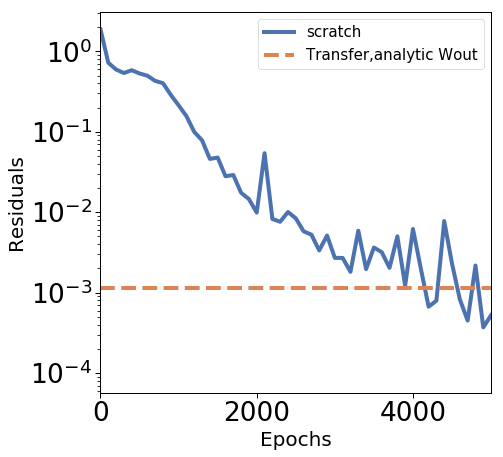

In [15]:
plt.figure(figsize=(7,7))
plt.plot(tpts[:],residuals_scratch,label='scratch')
# plt.plot(tpts,residuals1[:-1],label='Transfer',c='black')
# plt.plot(tpts,residuals[:-1],label='Transfer, frozen H')
# plt.plot(tpts[:len(residuals2)],residuals2[:-1],linestyle='--',label='Transfer,analytic Wout')

plt.plot(tpts,(res_init*torch.ones(len(tpts))).detach().numpy(),linestyle='--',label='Transfer,analytic Wout')
plt.yscale('log')
plt.xlabel("Epochs")
plt.ylabel("Residuals")
plt.xlim([0,5000])
# plt.ylim([10**-3,10**1])
plt.legend(fontsize=15)
plt.savefig('residuals_second_order.pdf',dpi=2400,bbox_inches='tight')